# Bottom Up Attention with Detectron2
In this notebook, I'm looking to explore how to capture regional features from the Flickr30K dataset using Detectron2. For every image in the dataset, we extract the bounding boxes using a segmentation model, then compute the features in the bounded image.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install dependencies: 
# !pip install pyyaml==5.1
# !pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 735.5 MB 14 kB/s 
     |████████████████████████████████| 17.3 MB 123 kB/s 
     |████████████████████████████████| 1.9 MB 38.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.11.0+cu113
    Uninstalling torchaudio-0.11.0+cu113:
      Successfully uninstalled torchaudio-0.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
1.8.0 True


In [39]:
# Some basic setup:
# Setup detectron2 logger
from collections import defaultdict
#import exdir
import torch
import nltk
from copy import copy
from tqdm.notebook import tqdm
from torchvision.datasets import Flickr30k
from torchvision import models
import torchvision.transforms as transforms
import detectron2
import torch.nn as nn
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.structures.image_list import ImageList
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import string
from multiprocessing import Pool

save_regional_features = True
save_global_features = False

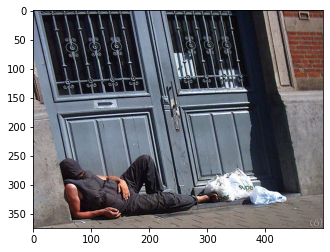

In [2]:
image_path = "/content/drive/MyDrive/ECE763_Projects/data/flickr30k/flickr30k-images/353913.jpg"
im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [3]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_68b088.pkl: 421MB [00:25, 16.2MB/s]                           


In [4]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0], device='cuda:0')
Boxes(tensor([[ 49.8907, 245.8973, 305.9599, 360.9300]], device='cuda:0'))


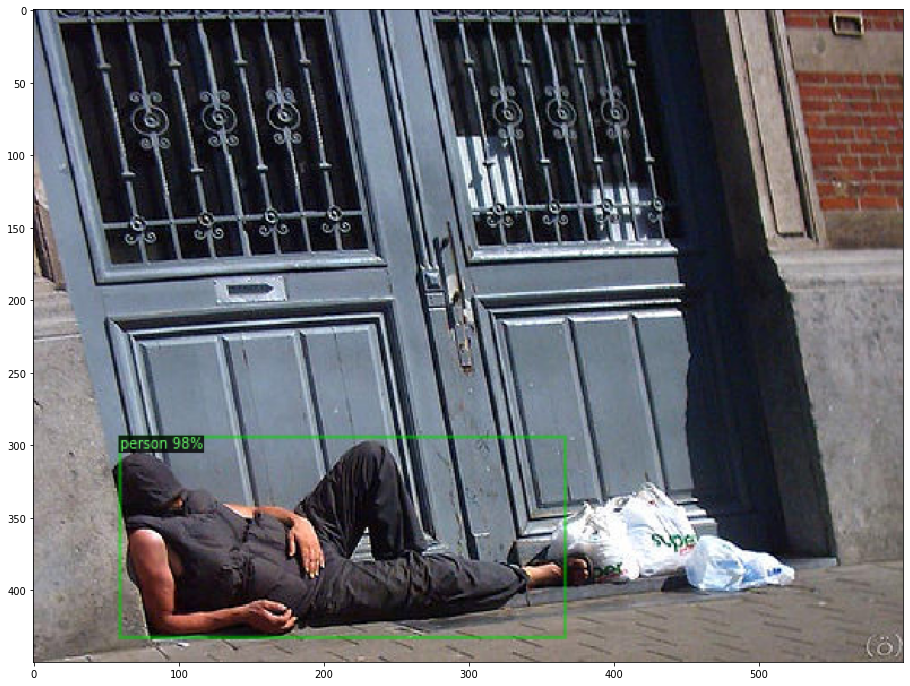

In [5]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,12))
plt.imshow(out.get_image()[:, :, ::-1])

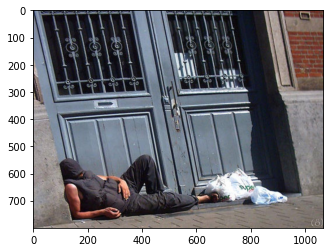

torch.Size([1, 3, 800, 1088])
before:  [Instances(num_instances=1, image_height=800, image_width=1067, fields=[pred_boxes: Boxes(tensor([[106.4668, 524.5809, 652.9185, 769.9840]], device='cuda:0')), scores: tensor([0.9799], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])]
after:  [Instances(num_instances=1, image_height=800, image_width=1067, fields=[pred_boxes: Boxes(tensor([[106.4668, 524.5809, 652.9185, 769.9840]], device='cuda:0')), scores: tensor([0.9799], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])]
torch.Size([1, 1024])


In [6]:
height, width = im.shape[:2]
img = predictor.aug.get_transform(im).apply_image(im)
plt.imshow(img)
plt.show()
img = torch.as_tensor(img.astype("float32").transpose(2,0,1))
images = ImageList.from_tensors([img])
inputs = [{"image":img, "height": height, "width":width}]
with torch.no_grad():
    data = predictor.model.preprocess_image(inputs)
    print(data.tensor.size())
    features = predictor.model.backbone(data.tensor)
    proposals, _ = predictor.model.proposal_generator(data, features, None)

    proposal_boxes = [x.proposal_boxes for x in proposals]
    features_list = [features[f] for f in predictor.model.roi_heads.in_features]
    proposal_rois = predictor.model.roi_heads.box_pooler(features_list,  proposal_boxes)
    region_features = predictor.model.roi_heads.box_head(proposal_rois)  
    predictions = predictor.model.roi_heads.box_predictor(region_features)
    preds, pred_ind = predictor.model.roi_heads.box_predictor.inference(predictions, proposals)
    print("before: ",preds)
    preds = predictor.model.roi_heads.forward_with_given_boxes(features, preds)
    print("after: ",preds)
    
    preds = predictor.model._postprocess(preds, inputs, images.image_sizes)
    feats = region_features[pred_ind]
print(feats.size())

In [8]:
# set up data
base_path = "/content/drive/MyDrive/ComputerVision/flickr30k/flickr30k-images"
ann_path = "/content/drive/MyDrive/ComputerVision/flickr30k/results_20130124.token"
torch_dataset = Flickr30k(base_path, ann_path)

In [10]:
!pip install exdir

     |████████████████████████████████| 109 kB 16.1 MB/s 
     |████████████████████████████████| 546 kB 51.5 MB/s 


In [11]:
import exdir

In [14]:
# create dataset 
dataset_path = "/content/drive/MyDrive/ComputerVision/"
archive = exdir.File(dataset_path)
train_archive = archive.require_group("train")
valid_archive = archive.require_group("valid")
test_archive = archive.require_group("test")

img_ids = torch_dataset.ids
train_ids = img_ids[: int(len(img_ids) * 0.8)]
val_ids = img_ids[int(len(img_ids) * 0.8) : int(len(img_ids) * 0.8) + int(len(img_ids) * 0.15)]
test_ids = img_ids[int(len(img_ids) * 0.8) + int(len(img_ids) * 0.15) :]
train_captions = defaultdict(list)
val_captions = defaultdict(list)
test_captions = defaultdict(list)

print(f"# Train Examples {len(train_ids)}")
print(f"# Validation Examples {len(val_ids)}")
print(f"# Test examples {len(test_ids)}")

# Train Examples 25426
# Validation Examples 4767
# Test examples 1590


In [15]:
# Set up ResNet Model for conventional image features
cnn_model = models.resnet152(pretrained=True)
cnn_model = nn.Sequential(*(list(cnn_model.children())[:-1])).cuda()
img = torch.tensor(im.astype("float32")).permute(2,0,1).unsqueeze(0).cuda()
print(img.shape)
feature_example = cnn_model(img)
print(feature_example.size())


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

torch.Size([1, 3, 375, 500])
torch.Size([1, 2048, 1, 1])


In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
words = defaultdict(lambda: 0)
max_caption_length = 30
if save_regional_features:
    predictor.model.eval()
token_stats = defaultdict(list)
ids = copy(img_ids)

for i, img_id in enumerate(tqdm(img_ids, desc="Loading Data")):
    image, captions = torch_dataset[i]
    image = np.asarray(image)
    if img_id in train_ids:
        store = train_archive
        cap_store = train_captions
    elif img_id in val_ids:
        store = valid_archive
        cap_store = val_captions
    else:
        store = test_archive
        cap_store = test_captions
    
    for cap in captions:
        cap = "".join(filter(lambda x: x not in string.punctuation, cap))
        tokens = nltk.tokenize.word_tokenize(cap.lower())
        token_stats["length"].append(len(tokens))
        if len(tokens) > max_caption_length - 2: # we don't want excessively long captions
            continue
        cap_store[img_id].append(cap)
        for toke in tokens:
            words[toke] += 1
            
    if len(cap_store[img_id]) <= 0:
        print(img_id)
        ids.remove(img_id) # remove image if we don't have enough captions
        continue
    
    if save_regional_features:
        image_group = store.require_group(img_id)     
        height, width = image.shape[:2]
        img = predictor.aug.get_transform(image).apply_image(image)
        img = torch.as_tensor(img.astype("float32").transpose(2,0,1)).cuda()
        images = ImageList.from_tensors([img])
        inputs = [{"image":img, "height": height, "width":width}]
        with torch.no_grad():
            data = predictor.model.preprocess_image(inputs)
            features = predictor.model.backbone(data.tensor)
            proposals, _ = predictor.model.proposal_generator(data, features, None)

            proposal_boxes = [x.proposal_boxes for x in proposals]
            features_list = [features[f] for f in predictor.model.roi_heads.in_features]
            proposal_rois = predictor.model.roi_heads.box_pooler(features_list,  proposal_boxes)
            region_features = predictor.model.roi_heads.box_head(proposal_rois)  
            predictions = predictor.model.roi_heads.box_predictor(region_features)
            preds, pred_ind = predictor.model.roi_heads.box_predictor.inference(predictions, proposals)
            preds = predictor.model.roi_heads.forward_with_given_boxes(features, preds)
            
            preds = predictor.model._postprocess(preds, inputs, images.image_sizes)
            feats = region_features[pred_ind]
            pred_boxes = ((preds[0]['instances']).get_fields())['pred_boxes']     
        #image_data = image_group.require_dataset("image", data=image)
        #feature_data = image_group.require_dataset("features", data=np.cpu().numpy())
        #region_data = image_group.require_dataset("region_features", data=feats.cpu().numpy())
        bbox_data =  image_group.require_dataset("bbox", data=pred_boxes.tensor.cpu().numpy())

Loading Data:   0%|          | 0/31783 [00:00<?, ?it/s]

19641


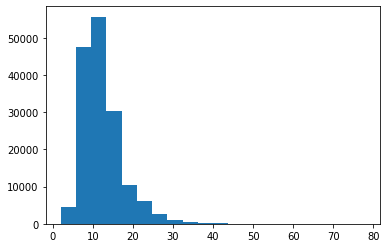

In [20]:
archive.attrs["max_cap_len"] = max_caption_length
plt.hist(token_stats["length"], 20)
print(len(words))
plt.show()

In [21]:
print(max(token_stats["length"]))
print(len(ids))
print(len(img_ids))

78
31783
31783


In [29]:
def store_captions(img_id, store_type, tokenized_captions, lengths):
    # store caption
    dataset_path = "/content/drive/MyDrive/ECE763_Projects/data/flickr30k"
    archive = exdir.File(dataset_path)
    store = archive.require_group(store_type)
    try:
        assert len(tokenized_captions) > 0
        assert len(lengths) > 0
        store[img_id].attrs["captions"] = tokenized_captions
        store[img_id].attrs["lengths"] = lengths
    except Exception as e:
        print(img_id)
        print(tokenized_captions)
        print(lengths)
        print(e)
        raise
    return 1

In [30]:
# build token-map
word_freqs = [(k, v) for k, v in words.items()]
word_freqs.sort(key=lambda x: x[1], reverse=True)
topk = word_freqs[:2000] # top 2K words
#topk = word_freqs[:1500]  # We select top K words to be the model's vocabulary
topk = [w for w, _ in topk]  # only care about the words
token_map = {token: i + 4 for i, token in enumerate(topk)}
token_map["<start>"] = 3
token_map["<end>"] = 1
token_map["<unc>"] = 2
token_map["<pad>"] = 0
res_captions = {}
res_lengths = {}
# store tokens for dataset
num_completed = 0
buffer = []
failed = []
t = ["998845445.jpg"]
with Pool(12) as pool:
    for img_id in tqdm(t, desc="Processing Captions"):
        if img_id in train_ids:
            store = "train"
            cap_store = train_captions
        elif img_id in val_ids:
            store = "valid"
            cap_store = val_captions
        else:
            store = "test"
            cap_store = test_captions
        tokenized_captions = []
        lengths = []
        for cap in cap_store[img_id]:
            if cap is None:
                failed.append(img_id)
                print("Empty Caption")
            tokens = nltk.tokenize.word_tokenize(cap.lower())
            lengths.append(len(tokens) + 2)
            # replace uncommon words
            res = copy(tokens)
            for i, toke in enumerate(tokens):
                if toke not in token_map.keys():
                    res[i] = token_map["<unc>"]
                else:
                    res[i] = token_map[toke]
            res.append(token_map["<end>"])
            res.insert(0, token_map["<start>"])

            # ensure equal length for all captions
            while len(res) < max_caption_length:
                res.append(token_map["<pad>"])
            tokenized_captions.append(res)
            
        buffer.append((img_id, store, tokenized_captions, lengths))
        # store caption
        if len(buffer) >= 6:
            res = [pool.apply_async(store_captions, x) for x in buffer]
            for r in res:
                r.wait()
                h = r.get()
                if h == 0:
                    print(store_captions[0])
                    failed.append(store_captions[0])
                num_completed += h
            buffer = []



Processing Captions:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
x = cap_store["998845445.jpg"]
print(res)

[3, 4, 8, 7, 4, 2, 27, 9, 22, 177, 12, 1950, 9, 2, 5, 6, 89, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [32]:
print(len(token_map))
print(num_completed)
print(len(ids))
print(len(topk))
print(failed)

2004
0
31783
2000
[]


In [33]:
archive.attrs["word_map"] = token_map
archive.attrs["max_cap_len"] = max_caption_length

In [34]:
# Check for empty arrays
checked_ids = []
number_of_detections = []
for mode in ["train", "valid", "test"]:
    store = archive.require_group(mode)
    for id in tqdm(store.keys(), desc=mode):
        detects = store[id]["region_features"].shape[0]
        checked_ids.append(id)
        number_of_detections.append(detects)

train: 0it [00:00, ?it/s]

valid: 0it [00:00, ?it/s]

test: 0it [00:00, ?it/s]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <a list of 40 Patch objects>)

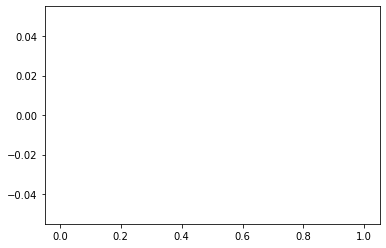

In [35]:
plt.hist(number_of_detections, bins=40)

In [36]:
print(max(number_of_detections))
print(min(number_of_detections))
print(np.sum(np.asarray(number_of_detections) == 0))
print(np.median(np.asarray(number_of_detections)))

ValueError: ignored

In [ ]:
# Remove below threshold
to_remove = []
for i, detect in enumerate(number_of_detections):
    if detect < 1 :
        to_remove.append(checked_ids[i])
for rem in to_remove:
    try:
        ids.remove(rem)
    except:
        continue

In [ ]:
archive.attrs["valid_ids"] = ids

In [ ]:
from data.augmentation import Flickr30KRegionalFeatures

dataset = Flickr30KRegionalFeatures(root="/home/jalexbox/Code/school/ece763/class_project/ImageCaptioningProject/flickr30k.exdir", max_detections=50, mode="train", fast_test=True)

ImportError: cannot import name 'Flickr30KRegionalFeatures' from 'data.augmentation' (/home/jalexbox/Code/school/ece763/class_project/ImageCaptioningProject/src/data/augmentation.py)

In [ ]:
idx = random.randint(0, len(dataset)-1)
features, cap, allcap = dataset[idx]
print(len(dataset))
print(f"Feature Size: {features.size()}, max: {torch.max(features):.4f}")
print(f"Cap Size: {cap.size()}")
print(f"Num Ref {len(allcap)}")

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
loader = DataLoader(dataset, batch_size=32, num_workers=8) 
for i, batch in tqdm(enumerate(loader)):
    feature, cap = batch
    assert 0 not in feature.shape
    assert 0 not in cap.shape

391it [00:20, 18.70it/s]


In [ ]:
i

NameError: name 'i' is not defined

In [ ]:
idx = random.randint(0, len(dataset) - 1)

d, cap, length, all_caps = dataset[idx]
print(d.size())
print(cap)
print(length)
print(all_caps)